### NN from scratch on MNIST Dataset (NN from Scratch followed from Samson Zhang, expanded) ###

In [ ]:
Zhang's Tutorial: https://youtu.be/w8yWXqWQYmU?si=AF7peo52QGfBtVyY
https://www.kaggle.com/competitions/digit-recognizer/

In [135]:
import numpy as np 
import pandas as pd
import os
from matplotlib import pyplot as plt

In [136]:
ACC_INTERVAL = 100 # interval at which we measure accuracy for dataplot
NUM_ITER = 1500 # number of iterations in training (currently set pretty high and could be overfitting)

#### Load Data, Preprocessing 

In [137]:
data = pd.read_csv('kaggle/input/train.csv')

data.head()

data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_test = data[0:1000].T
Y_test = data_test[0]
X_test = data_test[1:n]
X_test = X_test / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.

_,m_train = X_train.shape


In [138]:
X_train[:, 0].shape
Y_train

array([5, 1, 2, ..., 6, 3, 8])

First we a normalized initialization of layers:

In [ ]:
def init_params():
    W1 = np.random.normal(size=(256, 784)) * np.sqrt(1./784)
    b1 = np.random.normal(size=(256, 1)) * np.sqrt(1./256)
    W2 = np.random.normal(size=(128, 256)) * np.sqrt(1./256)
    b2 = np.random.normal(size=(128, 1)) * np.sqrt(1./128)
    W3 = np.random.normal(size=(64, 128)) * np.sqrt(1./128)  # Adjusting for an additional layer
    b3 = np.random.normal(size=(64, 1)) * np.sqrt(1./64)
    W4 = np.random.normal(size=(10, 64)) * np.sqrt(1./64)  # Corrected for final output
    b4 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    return W1, b1, W2, b2, W3, b3, W4, b4

Impl. of ReLU activation, softmax, forward / backward propagation

In [139]:


def ReLU(Z):
    return np.maximum(0, Z)

def deriv_ReLU(Z):
    return Z > 0

def softmax(Z):
    A =  np.exp(Z) / sum(np.exp(Z))
    return A

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, int(Y.max()) + 1))
    one_hot_Y[np.arange(Y.size), Y.astype(int)] = 1
    # each row is an example, so we want one column to be ex.
    one_hot_Y = one_hot_Y.T
    return one_hot_Y


def forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = ReLU(Z3)
    Z4 = W4.dot(A3) + b4
    A4 = softmax(Z4)
    return Z1, A1, Z2, A2, Z3, A3, Z4, A4

def back_prop(Z1, A1, Z2, A2, Z3, A3, Z4, A4, W1, W2, W3, W4, X, Y):
    one_hot_Y = one_hot(Y)

    dZ4 = A4 - one_hot_Y
    dW4 = 1 / m * dZ4.dot(A3.T)
    db4 = 1 / m * np.sum(dZ4, axis=1, keepdims=True)

    dA3 = W4.T.dot(dZ4)
    dZ3 = dA3 * deriv_ReLU(Z3)
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)

    dA2 = W3.T.dot(dZ3)
    dZ2 = dA2 * deriv_ReLU(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = W2.T.dot(dZ2)
    dZ1 = dA1 * deriv_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2, dW3, db3, dW4, db4

def update_params(W1, b1, W2, b2, W3, b3, W4, b4, dW1, db1, dW2, db2, dW3, db3, dW4, db4, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    W3 -= alpha * dW3
    b3 -= alpha * db3
    W4 -= alpha * dW4
    b4 -= alpha * db4
    return W1, b1, W2, b2, W3, b3, W4, b4

In [140]:
def get_predictions(A4):
    return np.argmax(A4, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size


def gradient_descent(X, Y, iterations, alpha):
    W1, b1, W2, b2, W3, b3, W4, b4 = init_params()
    accuracies = []
    iteration_steps = []
    
    for i in range(iterations):
        # Updated for an additional forward propagation step
        Z1, A1, Z2, A2, Z3, A3, Z4, A4 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X)
        # Updated for an additional backward propagation step
        dW1, db1, dW2, db2, dW3, db3, dW4, db4 = back_prop(Z1, A1, Z2, A2, Z3, A3, Z4, A4, W1, W2, W3, W4, X, Y)
        # Updated for additional parameters update step
        W1, b1, W2, b2, W3, b3, W4, b4 = update_params(W1, b1, W2, b2, W3, b3, W4, b4, dW1, db1, dW2, db2, dW3, db3, dW4, db4, alpha)

        if i % ACC_INTERVAL == 0 or i == iterations - 1:
            # Use A3 for predictions since it's the output of the last layer
            predictions = get_predictions(A4)
            acc = get_accuracy(predictions, Y)
            print("Iteration: ", i)
            print("Accuracy: ", acc)
            accuracies.append(acc)
            iteration_steps.append(i)

    # Return the parameters including those for the third layer
    return W1, b1, W2, b2, W3, b3, W4, b4, accuracies

hyperparameter tune alpha to select for the best alpha W.R.T. accuracy:

In [148]:
alphas = [0.5, 0.45, 0.4, 0.35, 0.3] #  0.25, 0.2, 0.15, 0.1, 0.05, 0.01]  # alpha values to train with.
best_accuracy = 0
best_params = {}
alpha_accuracies = {}  # To store accuracies for each alpha training session

for alpha in alphas:
    W1, b1, W2, b2, W3, b3, W4, b4, accuracies = gradient_descent(X_train, Y_train, NUM_ITER, alpha)
    alpha_accuracies[alpha] = accuracies
    final_accuracy = accuracies[-1]  # The final accuracy for this alpha

    if final_accuracy > best_accuracy:
        best_accuracy = final_accuracy
        best_params = {
            'W1': W1, 'b1': b1,
            'W2': W2, 'b2': b2,
            'W3': W3, 'b3': b3,
            'W4': W4, 'b4': b4,
            'alpha': alpha,
            'accuracy': best_accuracy
        }

[9 9 9 ... 4 9 9] [5 1 2 ... 6 3 8]
Iteration:  0
Accuracy:  0.091
[5 1 1 ... 6 8 8] [5 1 2 ... 6 3 8]
Iteration:  100
Accuracy:  0.8178536585365853
[5 1 2 ... 6 7 8] [5 1 2 ... 6 3 8]
Iteration:  200
Accuracy:  0.9510243902439024
[5 1 2 ... 6 7 8] [5 1 2 ... 6 3 8]
Iteration:  300
Accuracy:  0.9729756097560975
[5 1 2 ... 6 8 8] [5 1 2 ... 6 3 8]
Iteration:  400
Accuracy:  0.9802439024390244
[5 1 2 ... 6 2 8] [5 1 2 ... 6 3 8]
Iteration:  500
Accuracy:  0.9703414634146341
[5 1 2 ... 6 3 8] [5 1 2 ... 6 3 8]
Iteration:  600
Accuracy:  0.9818780487804878
[5 1 2 ... 6 3 8] [5 1 2 ... 6 3 8]
Iteration:  700
Accuracy:  0.9880975609756097
[5 1 2 ... 6 3 8] [5 1 2 ... 6 3 8]
Iteration:  800
Accuracy:  0.9920487804878049
[5 1 2 ... 6 7 8] [5 1 2 ... 6 3 8]
Iteration:  900
Accuracy:  0.8821707317073171
[5 1 2 ... 6 3 8] [5 1 2 ... 6 3 8]
Iteration:  1000
Accuracy:  0.9600731707317073
[5 1 2 ... 6 3 8] [5 1 2 ... 6 3 8]
Iteration:  1100
Accuracy:  0.971
[5 1 2 ... 6 3 8] [5 1 2 ... 6 3 8]
Iterat

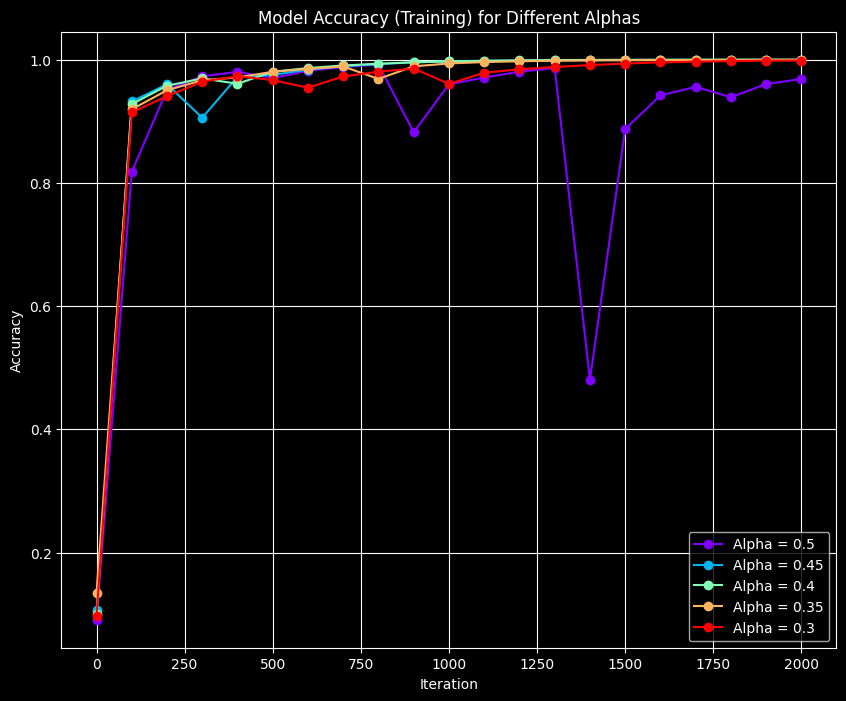

In [149]:
iteration_steps = np.arange(0, NUM_ITER, ACC_INTERVAL).tolist() + [NUM_ITER-1] 
plt.figure(figsize=(10, 8))
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(alphas))))

for alpha, accuracies in alpha_accuracies.items():
    plt.plot(iteration_steps, accuracies, marker='o', color=next(colors), label=f'Alpha = {alpha}')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Model Accuracy (Training) for Different Alphas')
plt.legend()
plt.grid(True)
plt.show()

^ (0.5 is exhibiting some of the oscillatory behavior we expect to see for high alpha values.) ^

In [150]:
def make_predictions(X, W1, b1, W2, b2, W3, b3, W4, b4):
    # Ensure forward_prop processes through all four layers, using the output from the fourth layer
    _, _, _, _, _, _, _, A4 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X)
    predictions = get_predictions(A4)  # Use A4, the output of the last layer
    return predictions


def test_prediction(index, W1, b1, W2, b2, W3, b3, W4, b4, X_train, Y_train):
    current_image = X_train[:, index, None]
    # Correction: Ensure you pass all parameters for the four layers
    prediction = make_predictions(current_image, W1, b1, W2, b2, W3, b3, W4, b4)
    label = Y_train[index]
    print("Prediction:", prediction)
    print("Label:", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.title(f'Predicted: {prediction}, Actual: {label}')
    plt.show()

# Example of how to call test_prediction
# test_prediction(0, *best_params, X_train, Y_train)
    

Prediction: [5]
Label: 5


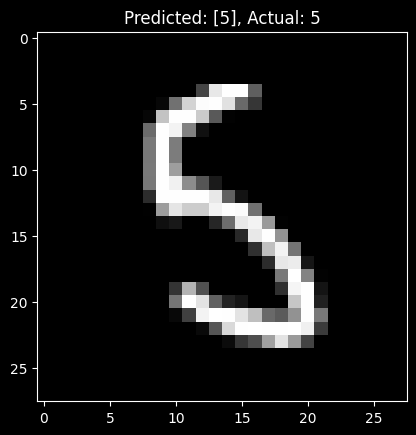

In [152]:
test_prediction(0, best_params['W1'], best_params['b1'], best_params['W2'], best_params['b2'], 
                best_params['W3'], best_params['b3'], best_params['W4'], best_params['b4'], 
                X_train, Y_train)

In [153]:

test_predictions = make_predictions(X_test, best_params['W1'], best_params['b1'], best_params['W2'], best_params['b2'], 
                best_params['W3'], best_params['b3'], best_params['W4'], best_params['b4'])

get_accuracy(test_predictions, Y_test)

[3 8 9 6 8 7 2 9 7 2 7 6 1 0 6 2 8 7 5 9 8 3 4 9 2 3 7 2 7 4 9 6 8 0 7 9 3
 7 5 7 0 0 6 3 6 1 0 1 9 4 7 3 3 1 1 3 5 9 0 9 9 8 9 7 2 4 5 3 0 3 7 3 9 3
 8 9 5 0 6 4 4 5 0 8 5 2 5 1 8 5 9 3 3 0 5 8 4 0 6 9 5 8 4 5 6 4 8 3 9 7 1
 3 9 2 2 0 6 7 5 5 9 5 2 2 0 9 8 0 7 4 1 6 8 6 3 4 9 4 9 5 7 1 3 4 5 0 1 0
 2 7 4 5 5 4 9 2 3 7 2 7 4 7 4 0 9 7 7 5 2 4 3 8 1 2 6 1 3 2 6 1 5 1 0 5 2
 1 8 4 4 2 7 4 0 0 5 7 5 0 4 4 1 5 3 1 8 7 6 3 8 2 4 2 7 7 3 6 7 6 1 1 9 4
 4 2 6 7 9 9 3 5 5 4 0 1 4 6 5 7 9 3 5 1 7 5 0 3 3 1 4 1 8 7 3 9 3 7 9 4 6
 6 0 7 1 0 3 5 3 8 4 8 6 2 0 2 4 8 5 7 7 4 9 9 7 7 3 6 8 8 1 6 8 5 3 5 7 1
 1 2 8 8 7 3 2 5 5 4 7 4 3 7 2 3 4 8 2 3 6 0 9 2 8 2 9 0 7 3 7 3 3 3 3 7 9
 9 3 0 4 3 7 2 1 8 0 8 7 6 7 4 4 6 4 7 4 9 4 3 8 2 2 0 4 1 7 2 0 1 1 8 5 2
 2 1 9 7 3 8 6 0 0 0 7 2 6 3 1 4 3 4 1 5 1 0 5 8 3 0 6 8 0 1 1 0 6 9 9 2 3
 4 3 9 3 4 8 8 6 3 3 2 8 3 1 6 0 7 2 4 1 3 8 1 7 3 5 3 6 3 9 1 1 0 3 5 5 6
 4 5 0 7 0 3 2 6 3 6 5 4 4 7 3 0 9 5 2 1 4 0 4 9 3 4 9 8 3 3 1 0 5 6 1 1 1
 3 4 9 1 4 0 6 5 6 3 2 9 

0.979

In [154]:
test_data_df = pd.read_csv('kaggle/input/test.csv')
test_data_df.head()


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [155]:
# Convert to NumPy array for numerical operations
test_data_np = np.array(test_data_df)

# There's no need to transpose the test data since we're not adding a bias row to it
# Normalize the pixel values
X_test_preprocessed = test_data_np / 255.
X_test_preprocessed = X_test_preprocessed.T

# Now, make predictions with the correctly shaped test data
print("Shape of X_test_preprocessed:", X_test_preprocessed.shape)
X_test_preprocessed[:, 0].shape

test_predictions_output = make_predictions(X_test_preprocessed, best_params['W1'], best_params['b1'], best_params['W2'], best_params['b2'], 
                best_params['W3'], best_params['b3'], best_params['W4'], best_params['b4'])
submission_df = pd.DataFrame({
    'ImageId': range(1, len(test_predictions_output) + 1),
    'Label': test_predictions_output  # Corrected to use the proper variable
})

submission_df.to_csv('kgl_submission.csv', index=False)

submission_df.to_csv('kgl_submission.csv', index = False)

Shape of X_test_preprocessed: (784, 28000)


After testing much lower alpha values and finding that they did not perform well, trying the upper range of alphas produced much better results.
I could keep tuning the value with more granularity surrounding 0.35, but 0.973 is good enough for me right now.